In [1]:
# %pip install folktables
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy import stats
from scipy.stats import chi2_contingency
from folktables import ACSDataSource, ACSEmployment

In [2]:
state_list = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
              'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
              'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
              'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
              'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR']

In [3]:
# Specify here which state and year the model should be trained (and tested) on
training_state = 'PA'
training_year = 2014
training_horizon = '1-Year'
# For task 6: Specify here in which state and when the model should be deployed
deployment_state = 'PA'
deployment_year = 2018
deployment_horizon = '1-Year'

# Setup

## Get training and testing data

In [4]:
def preprocess_data(features, label, group):
  # Age
  ix_right_age_group = (features[:,0]>=25) & (features[:,0]<=65)
  features = features[ix_right_age_group]
  label = label[ix_right_age_group]
  group = group[ix_right_age_group]
  # Race
  ix_bw = (group==1) | (group==2)
  features = features[ix_bw]
  label = label[ix_bw]
  group = group[ix_bw]

  return (features, label, group)

In [5]:
from folktables import ACSDataSource, ACSEmployment
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

data_source = ACSDataSource(survey_year=training_year, horizon=training_horizon, survey='person')
acs_data = data_source.get_data(states=[training_state], download=True)
features, label, group = ACSEmployment.df_to_numpy(acs_data)
features, label, group = preprocess_data(features, label, group)

### How successful are the job coaches?
Base rate: Probability of finding employment within the first year of working with the job coaches

In [6]:
np.mean(label)

np.float64(0.710184182015168)

## Train the model

In [7]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


## Make predictions

In [8]:
yhat = model.predict(X_test)
scores = model.predict_proba(X_test)[:,1]

# Identify groups
white_mask = group_test == 1
black_mask = group_test == 2

print(f"Test set: {len(y_test)} samples")
print(f"White: {np.sum(white_mask)} ({100*np.sum(white_mask)/len(y_test):.1f}%)")
print(f"Black: {np.sum(black_mask)} ({100*np.sum(black_mask)/len(y_test):.1f}%)\n")


Test set: 12922 samples
White: 11951 (92.5%)
Black: 971 (7.5%)



# Task 1


Accuracy: 0.7650
Baseline (majority class): 0.7089

✓ Calibration plot saved as 'task1_calibration.png'


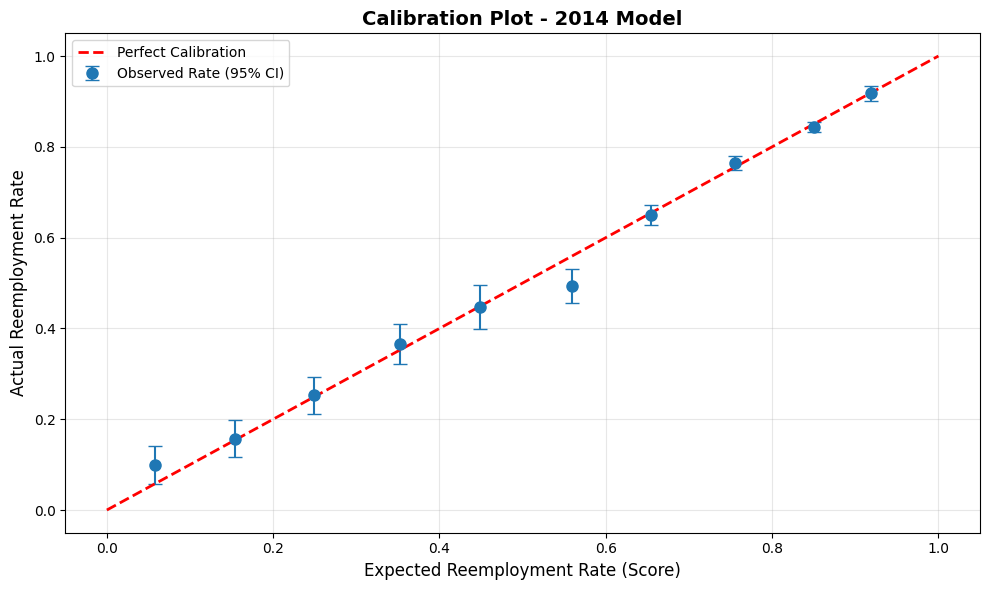

In [9]:
# 1.1 Accuracy
accuracy = accuracy_score(y_test, yhat)
baseline = max(np.mean(y_test), 1 - np.mean(y_test))
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Baseline (majority class): {baseline:.4f}")

# 1.2 Calibration
bins = np.linspace(0, 1, 11)
bin_indices = np.digitize(scores, bins) - 1
bin_indices = np.clip(bin_indices, 0, 9)

x_calibration = []
y_calibration = []
conf_intervals = []

for i in range(10):
    mask = bin_indices == i
    if np.sum(mask) > 0:
        x_i = np.mean(scores[mask])
        y_i = np.mean(y_test[mask])
        n = np.sum(mask)
        se = np.sqrt(y_i * (1 - y_i) / n)
        ci = 1.96 * se
        
        x_calibration.append(x_i)
        y_calibration.append(y_i)
        conf_intervals.append(ci)

# Calibration plot
plt.figure(figsize=(10, 6))
plt.errorbar(x_calibration, y_calibration, yerr=conf_intervals,
             fmt='o', capsize=5, label='Observed Rate (95% CI)', markersize=8)
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Calibration')
plt.xlabel('Expected Reemployment Rate (Score)', fontsize=12)
plt.ylabel('Actual Reemployment Rate', fontsize=12)
plt.title('Calibration Plot - 2014 Model', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('task1_calibration.png', dpi=300, bbox_inches='tight')
print("\n✓ Calibration plot saved as 'task1_calibration.png'")

# Task 2

/var/folders/p6/bwkhlx9j3bb74ks06svvcdwr0000gn/T/ipykernel_79173/1027786572.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([scores[white_mask], scores[black_mask]],



✓ Score distributions saved as 'task2_score_distributions.png'

Score Statistics:
White - Mean: 0.7250, Median: 0.7825
Black - Mean: 0.5532, Median: 0.6184

Bin             White Rate   Black Rate   p-value    Significant
----------------------------------------------------------------------
[0.0, 0.1)      0.0815       0.1404       0.3253     
[0.1, 0.2)      0.1622       0.1429       0.8427     
[0.2, 0.3)      0.2438       0.3051       0.3989     
[0.3, 0.4)      0.3886       0.2258       0.0199     *
[0.4, 0.5)      0.4750       0.3289       0.0297     *
[0.5, 0.6)      0.4991       0.4701       0.6120     
[0.6, 0.7)      0.6552       0.5989       0.1591     
[0.7, 0.8)      0.7617       0.8047       0.1762     
[0.8, 0.9)      0.8421       0.8729       0.4361     

✓ Group calibration plots saved as 'task2_calibration_by_group.png'

Metric     White        Black        Difference   Abs Diff
-----------------------------------------------------------------
BR         0.7229      

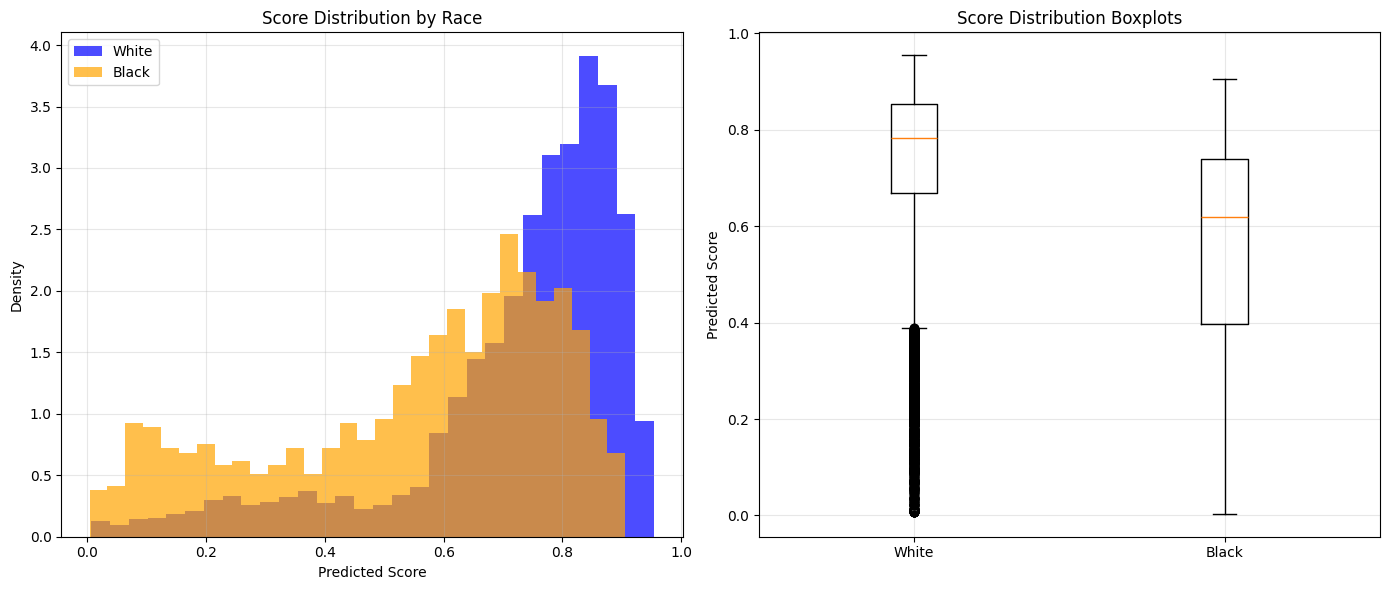

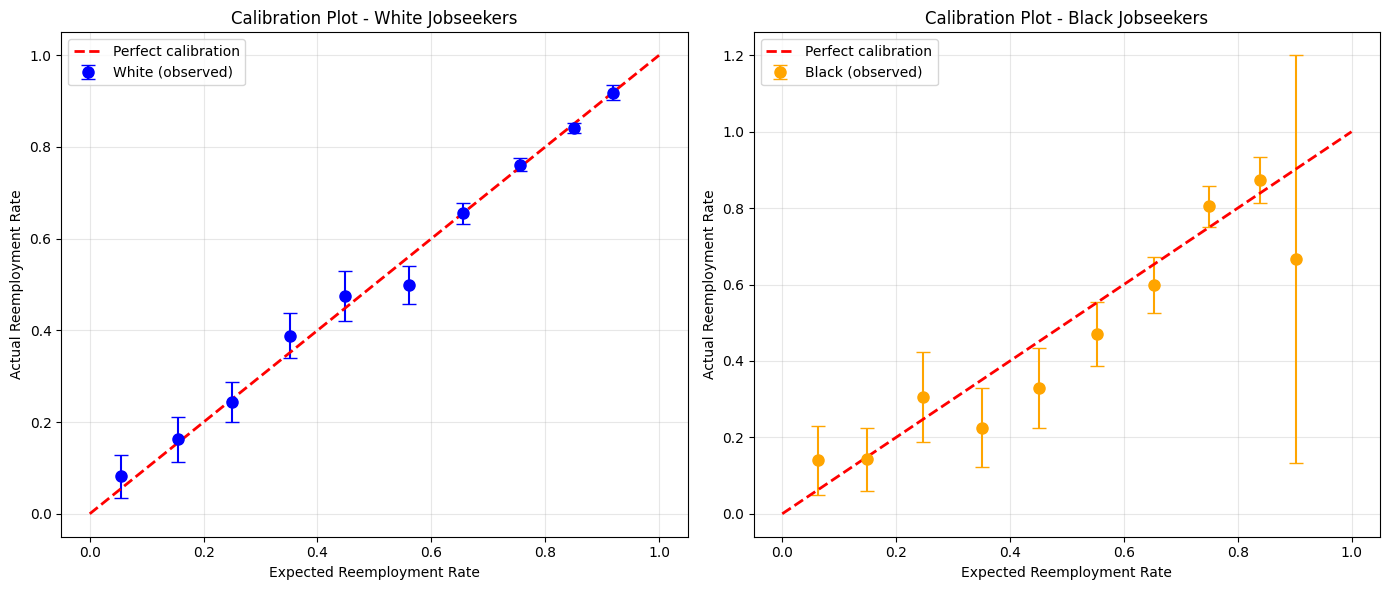

In [10]:
# 2.1 Score distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(scores[white_mask], bins=30, alpha=0.7, label='White', density=True, color='blue')
axes[0].hist(scores[black_mask], bins=30, alpha=0.7, label='Black', density=True, color='orange')
axes[0].set_xlabel('Predicted Score')
axes[0].set_ylabel('Density')
axes[0].set_title('Score Distribution by Race')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].boxplot([scores[white_mask], scores[black_mask]], 
                labels=['White', 'Black'])
axes[1].set_ylabel('Predicted Score')
axes[1].set_title('Score Distribution Boxplots')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('task2_score_distributions.png', dpi=300, bbox_inches='tight')
print("\n✓ Score distributions saved as 'task2_score_distributions.png'")

print(f"\nScore Statistics:")
print(f"White - Mean: {np.mean(scores[white_mask]):.4f}, Median: {np.median(scores[white_mask]):.4f}")
print(f"Black - Mean: {np.mean(scores[black_mask]):.4f}, Median: {np.median(scores[black_mask]):.4f}")

# 2.2 Calibration between groups
print(f"\n{'Bin':<15} {'White Rate':<12} {'Black Rate':<12} {'p-value':<10} {'Significant'}")
print("-"*70)

for i in range(10):
    bin_start, bin_end = bins[i], bins[i+1]
    
    in_bin_white = white_mask & (scores >= bin_start) & (scores < bin_end)
    in_bin_black = black_mask & (scores >= bin_start) & (scores < bin_end)
    
    if np.sum(in_bin_white) > 5 and np.sum(in_bin_black) > 5:
        contingency = np.array([
            [np.sum(y_test[in_bin_white]), np.sum(~y_test[in_bin_white].astype(bool))],
            [np.sum(y_test[in_bin_black]), np.sum(~y_test[in_bin_black].astype(bool))]
        ])
        
        chi2, p_value, _, _ = chi2_contingency(contingency)
        
        white_rate = np.mean(y_test[in_bin_white])
        black_rate = np.mean(y_test[in_bin_black])
        
        sig = '*' if p_value < 0.05 else ''
        bin_label = f"[{bin_start:.1f}, {bin_end:.1f})"
        print(f"{bin_label:<15} {white_rate:<12.4f} {black_rate:<12.4f} {p_value:<10.4f} {sig}")

# 2.3 Separate calibration plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for group_val, mask, ax, color, label in [
    (1, white_mask, axes[0], 'blue', 'White'),
    (2, black_mask, axes[1], 'orange', 'Black')
]:
    x_cal, y_cal, ci_cal = [], [], []
    
    for i in range(10):
        bin_mask = mask & (bin_indices == i)
        if np.sum(bin_mask) > 0:
            x_i = np.mean(scores[bin_mask])
            y_i = np.mean(y_test[bin_mask])
            n = np.sum(bin_mask)
            se = np.sqrt(y_i * (1 - y_i) / n) if n > 0 else 0
            
            x_cal.append(x_i)
            y_cal.append(y_i)
            ci_cal.append(1.96 * se)
    
    ax.errorbar(x_cal, y_cal, yerr=ci_cal, fmt='o', 
                capsize=5, color=color, label=f'{label} (observed)', markersize=8)
    ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect calibration')
    ax.set_xlabel('Expected Reemployment Rate')
    ax.set_ylabel('Actual Reemployment Rate')
    ax.set_title(f'Calibration Plot - {label} Jobseekers')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('task2_calibration_by_group.png', dpi=300, bbox_inches='tight')
print("\n✓ Group calibration plots saved as 'task2_calibration_by_group.png'")

# 2.4 Fairness metrics comparison
def calculate_metrics(y_true, y_pred, group_mask):
    """Calculate all relevant fairness metrics for a group"""
    y_true_g = y_true[group_mask]
    y_pred_g = y_pred[group_mask]
    
    # Base Rate (BR): P(Y=1)
    br = np.mean(y_true_g)
    
    # Positive Rate (PR): P(D=1)
    pr = np.mean(y_pred_g)
    
    # True Positive Rate (TPR): P(D=1|Y=1)
    tpr = np.sum((y_pred_g == 1) & (y_true_g == 1)) / np.sum(y_true_g) if np.sum(y_true_g) > 0 else 0
    
    # False Negative Rate (FNR): P(D=0|Y=1)
    fnr = 1 - tpr
    
    # False Positive Rate (FPR): P(D=1|Y=0)
    fpr = np.sum((y_pred_g == 1) & (y_true_g == 0)) / np.sum(y_true_g == 0) if np.sum(y_true_g == 0) > 0 else 0
    
    # True Negative Rate (TNR): P(D=0|Y=0)
    tnr = 1 - fpr
    
    return {'BR': br, 'PR': pr, 'TPR': tpr, 'FNR': fnr, 'FPR': fpr, 'TNR': tnr}

metrics_white = calculate_metrics(y_test, yhat, white_mask)
metrics_black = calculate_metrics(y_test, yhat, black_mask)

print(f"\n{'Metric':<10} {'White':<12} {'Black':<12} {'Difference':<12} {'Abs Diff'}")
print("-"*65)
for metric in ['BR', 'PR', 'TPR', 'FNR', 'FPR', 'TNR']:
    diff = metrics_white[metric] - metrics_black[metric]
    print(f"{metric:<10} {metrics_white[metric]:<12.4f} {metrics_black[metric]:<12.4f} {diff:<+12.4f} {abs(diff):.4f}")

# Task 3


Decision Maker Utility Matrix (in 1000 CHF):

        Y=0 (No Job)  |  Y=1 (Job Found)
D=0     -60           |  -30
D=1     -50           |  +10

Explanation:
D=1, Y=1: -20k (program) + 30k (saved unemployment) = +10k
D=1, Y=0: -20k (program) - 30k (unemployment year 2) = -50k
D=0, Y=1: -30k (unemployment year 1) = -30k
D=0, Y=0: -30k (year 1) - 30k (year 2) = -60k

Optimal Threshold: 0.00
Total Utility at optimal threshold: -96.44 Million CHF

✓ Utility curve saved as 'task3_utility_curve.png'


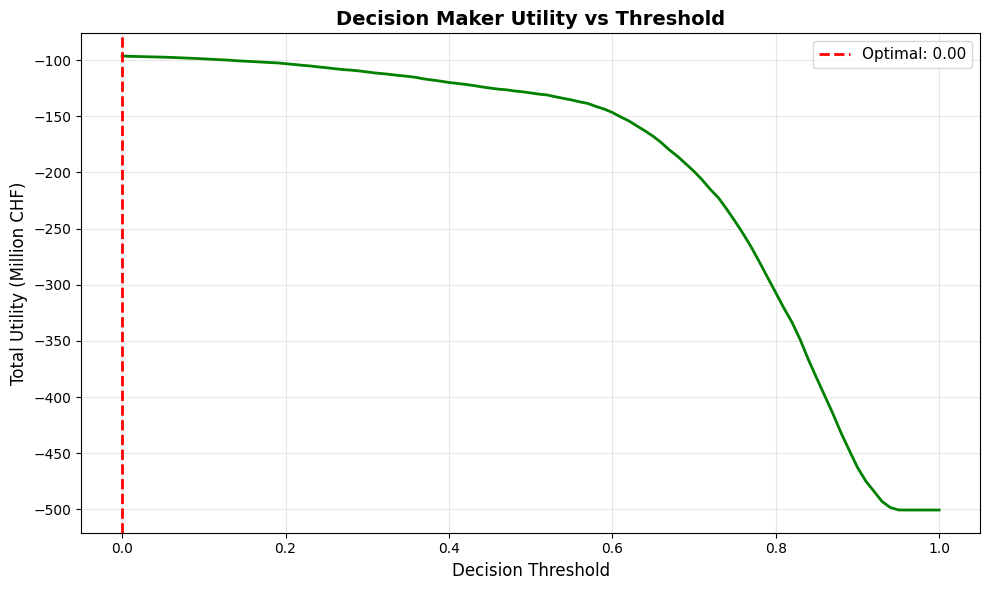

In [11]:
# Utility Matrix (in 1000 CHF)
U_DM = np.array([
    [-60, -30],  # D=0: No coaching
    [-50, +10]   # D=1: Coaching
])

print("\nDecision Maker Utility Matrix (in 1000 CHF):")
print("\n        Y=0 (No Job)  |  Y=1 (Job Found)")
print("D=0     -60           |  -30")
print("D=1     -50           |  +10")

print("\nExplanation:")
print("D=1, Y=1: -20k (program) + 30k (saved unemployment) = +10k")
print("D=1, Y=0: -20k (program) - 30k (unemployment year 2) = -50k")
print("D=0, Y=1: -30k (unemployment year 1) = -30k")
print("D=0, Y=0: -30k (year 1) - 30k (year 2) = -60k")

# Find optimal threshold
thresholds = np.arange(0, 1.01, 0.01)
utilities = []

for threshold in thresholds:
    decisions = (scores >= threshold).astype(int)
    
    total_utility = 0
    for d in [0, 1]:
        for y in [0, 1]:
            count = np.sum((decisions == d) & (y_test == y))
            total_utility += count * U_DM[d, y]
    
    utilities.append(total_utility)

utilities = np.array(utilities)
optimal_idx = np.argmax(utilities)
optimal_threshold = thresholds[optimal_idx]
optimal_utility = utilities[optimal_idx]

print(f"\nOptimal Threshold: {optimal_threshold:.2f}")
print(f"Total Utility at optimal threshold: {optimal_utility/1000:.2f} Million CHF")

# Plot utility curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, utilities / 1000, linewidth=2, color='green')
plt.axvline(optimal_threshold, color='r', linestyle='--', linewidth=2,
            label=f'Optimal: {optimal_threshold:.2f}')
plt.xlabel('Decision Threshold', fontsize=12)
plt.ylabel('Total Utility (Million CHF)', fontsize=12)
plt.title('Decision Maker Utility vs Threshold', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('task3_utility_curve.png', dpi=300, bbox_inches='tight')
print("\n✓ Utility curve saved as 'task3_utility_curve.png'")


# Task 4


TASK 4: FAIRNESS CRITERION

Decision Subject Utility Matrix:

        Y=0 (No Job)  |  Y=1 (Job Found)
D=0     0.0           |  0.5
D=1     0.2           |  1.0

Justifier J: Y (potential to benefit from coaching)
Morally relevant value: J=1 (would find job with coaching)

Fairness Criterion: Equal Opportunity
P(D=1 | A=white, Y=1) = P(D=1 | A=black, Y=1)
Equivalently: TPR(white) = TPR(black)

At optimal DM threshold (0.00):
TPR White: 1.0000
TPR Black: 1.0000
Difference: 0.0000

Contingency table (Y=1 cases):
           D=1    D=0
White:     8639   0     
Black:     522    0     

⚠️  WARNING: Contingency table has cells with count < 5 or zero.
   Chi-squared test may not be reliable. Using alternative approach.

✅ Perfect fairness: Both groups have TPR = 1.0
   All individuals who would benefit (Y=1) receive coaching.
   Statistical test not needed - perfect equality achieved.

✓ Fairness check plot saved as 'task4_fairness_check.png'


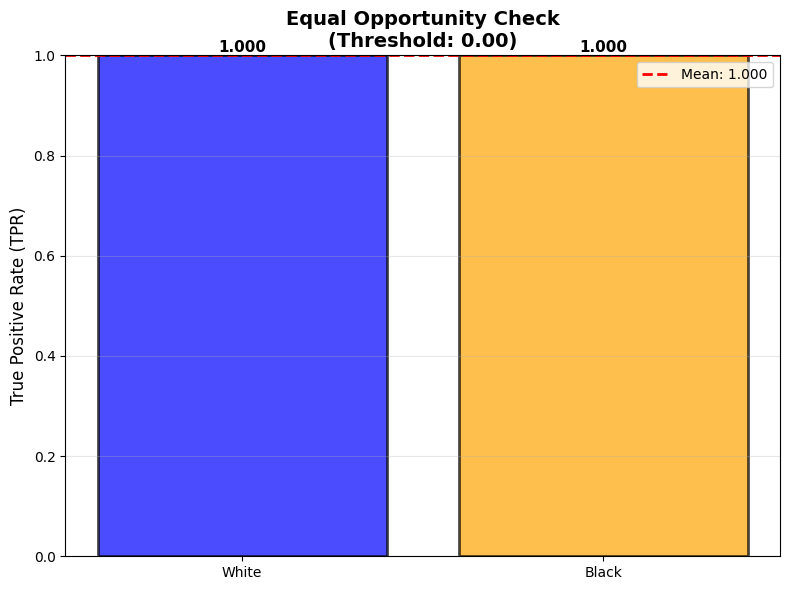

In [12]:
# ============================================================================
# TASK 4: Fairness Criterion (FIXED)
# ============================================================================

print("\n" + "="*80)
print("TASK 4: FAIRNESS CRITERION")
print("="*80)

# Decision Subject Utility Matrix
V_DS = np.array([
    [0.0, 0.5],  # D=0: No coaching
    [0.2, 1.0]   # D=1: Coaching
])

print("\nDecision Subject Utility Matrix:")
print("\n        Y=0 (No Job)  |  Y=1 (Job Found)")
print("D=0     0.0           |  0.5")
print("D=1     0.2           |  1.0")

print("\nJustifier J: Y (potential to benefit from coaching)")
print("Morally relevant value: J=1 (would find job with coaching)")
print("\nFairness Criterion: Equal Opportunity")
print("P(D=1 | A=white, Y=1) = P(D=1 | A=black, Y=1)")
print("Equivalently: TPR(white) = TPR(black)")

# Check fairness criterion with optimal DM threshold
def calculate_tpr(y_true, decisions, group_mask):
    """True Positive Rate: P(D=1|Y=1)"""
    positives = y_true[group_mask] == 1
    if np.sum(positives) == 0:
        return 0
    tp = np.sum((decisions[group_mask] == 1) & (y_true[group_mask] == 1))
    return tp / np.sum(positives)

decisions_optimal = (scores >= optimal_threshold).astype(int)

tpr_white = calculate_tpr(y_test, decisions_optimal, white_mask)
tpr_black = calculate_tpr(y_test, decisions_optimal, black_mask)

print(f"\nAt optimal DM threshold ({optimal_threshold:.2f}):")
print(f"TPR White: {tpr_white:.4f}")
print(f"TPR Black: {tpr_black:.4f}")
print(f"Difference: {abs(tpr_white - tpr_black):.4f}")

# Statistical test - WITH ERROR HANDLING
white_y1 = white_mask & (y_test == 1)
black_y1 = black_mask & (y_test == 1)

contingency_tpr = np.array([
    [np.sum(decisions_optimal[white_y1] == 1), np.sum(decisions_optimal[white_y1] == 0)],
    [np.sum(decisions_optimal[black_y1] == 1), np.sum(decisions_optimal[black_y1] == 0)]
])

print(f"\nContingency table (Y=1 cases):")
print(f"           D=1    D=0")
print(f"White:     {contingency_tpr[0,0]:<6} {contingency_tpr[0,1]:<6}")
print(f"Black:     {contingency_tpr[1,0]:<6} {contingency_tpr[1,1]:<6}")

# Check if chi-square test is applicable
if np.any(contingency_tpr == 0) or np.min(contingency_tpr) < 5:
    print(f"\n⚠️  WARNING: Contingency table has cells with count < 5 or zero.")
    print("   Chi-squared test may not be reliable. Using alternative approach.")
    
    # Alternative: Direct comparison with binomial test or permutation test
    # Or simply report that the groups are identical/nearly identical
    if tpr_white == tpr_black == 1.0:
        print("\n✅ Perfect fairness: Both groups have TPR = 1.0")
        print("   All individuals who would benefit (Y=1) receive coaching.")
        print("   Statistical test not needed - perfect equality achieved.")
    elif tpr_white == tpr_black:
        print(f"\n✅ Perfect fairness: Both groups have identical TPR = {tpr_white:.4f}")
        print("   Statistical test not needed - perfect equality achieved.")
    else:
        # Use Fisher's exact test for small samples
        from scipy.stats import fisher_exact
        try:
            _, p_value = fisher_exact(contingency_tpr)
            print(f"\nFisher's exact test: p = {p_value:.4f}")
            if p_value < 0.05:
                print("❌ Fairness criterion is NOT fulfilled (p < 0.05)")
            else:
                print("✅ Fairness criterion is fulfilled (p >= 0.05)")
        except Exception as e:
            print(f"\n⚠️  Cannot perform statistical test: {e}")
            print(f"   Manual assessment: TPR difference = {abs(tpr_white - tpr_black):.4f}")
            if abs(tpr_white - tpr_black) < 0.05:
                print("   ✅ Difference < 0.05 - practically fair")
            else:
                print("   ❌ Difference >= 0.05 - may be unfair")
else:
    # Standard chi-square test when applicable
    chi2, p_value, _, _ = chi2_contingency(contingency_tpr)
    print(f"\nChi-squared test: χ² = {chi2:.4f}, p = {p_value:.4f}")
    
    if p_value < 0.05:
        print("❌ Fairness criterion is NOT fulfilled (p < 0.05)")
        print("   There is a statistically significant difference in TPR between groups.")
    else:
        print("✅ Fairness criterion is fulfilled (p >= 0.05)")
        print("   No statistically significant difference in TPR between groups.")

# Visualization
fig, ax = plt.subplots(figsize=(8, 6))
groups = ['White', 'Black']
tprs = [tpr_white, tpr_black]
colors = ['blue', 'orange']

bars = ax.bar(groups, tprs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('True Positive Rate (TPR)', fontsize=12)
ax.set_title(f'Equal Opportunity Check\n(Threshold: {optimal_threshold:.2f})', 
             fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])
ax.axhline(np.mean(tprs), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {np.mean(tprs):.3f}')
ax.grid(True, alpha=0.3, axis='y')
ax.legend(fontsize=10)

for bar, tpr in zip(bars, tprs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{tpr:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('task4_fairness_check.png', dpi=300, bbox_inches='tight')
print("\n✓ Fairness check plot saved as 'task4_fairness_check.png'")

# Task 5


Calculating Pareto front (this may take a moment)...

Total threshold combinations: 10201
Pareto-optimal points: 1

Chosen Thresholds:
  White: 0.00
  Black: 0.00
  Utility: -96.44 Million CHF
  TPR Difference: 0.0000
  TPR White: 1.0000
  TPR Black: 1.0000

✓ Pareto front saved as 'task5_pareto_front.png'


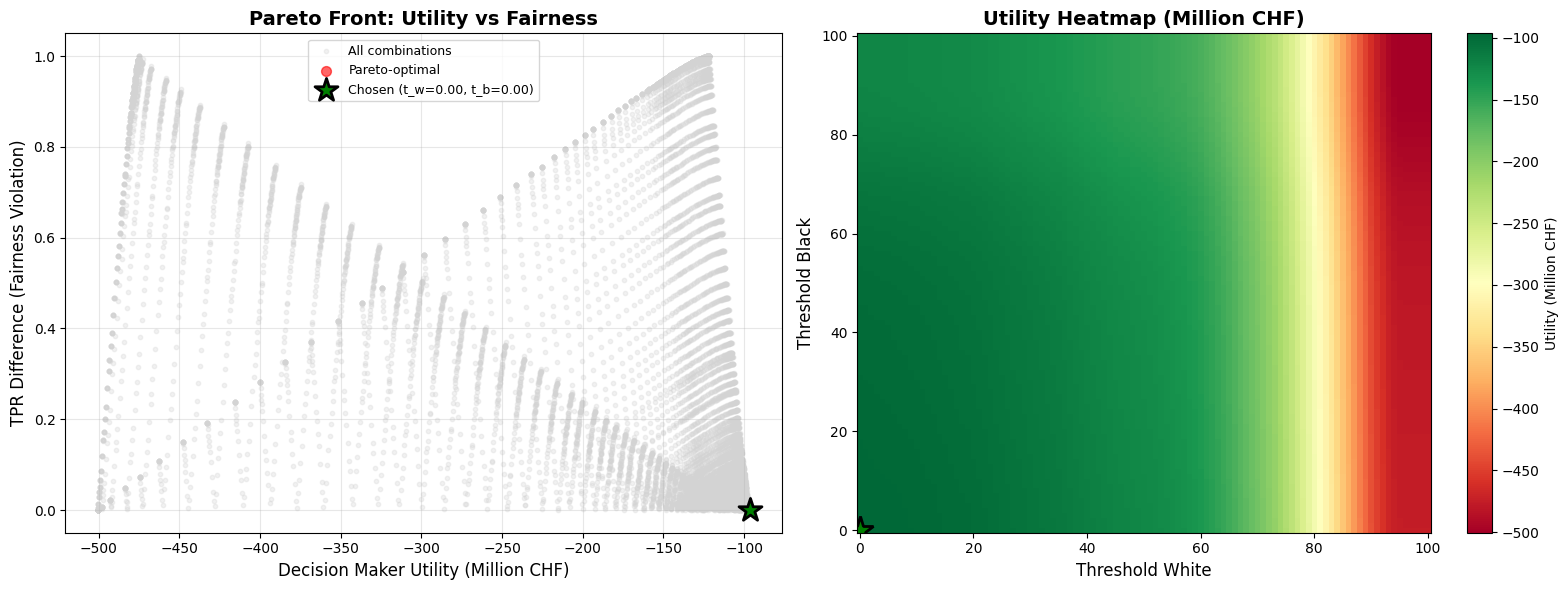

In [13]:
print("\nCalculating Pareto front (this may take a moment)...")

# Calculate for all threshold combinations
results = []

for t_white in thresholds:
    for t_black in thresholds:
        decisions_white = (scores[white_mask] >= t_white).astype(int)
        decisions_black = (scores[black_mask] >= t_black).astype(int)
        
        decisions_combined = np.zeros_like(yhat)
        decisions_combined[white_mask] = decisions_white
        decisions_combined[black_mask] = decisions_black
        
        # DM Utility
        total_utility = 0
        for d in [0, 1]:
            for y in [0, 1]:
                count = np.sum((decisions_combined == d) & (y_test == y))
                total_utility += count * U_DM[d, y]
        
        # Fairness Metric: TPR Difference
        tpr_w = calculate_tpr(y_test, decisions_combined, white_mask)
        tpr_b = calculate_tpr(y_test, decisions_combined, black_mask)
        tpr_diff = abs(tpr_w - tpr_b)
        
        results.append({
            't_white': t_white,
            't_black': t_black,
            'utility': total_utility,
            'fairness': -tpr_diff,  # Negative so higher is better
            'tpr_white': tpr_w,
            'tpr_black': tpr_b,
            'tpr_diff': tpr_diff
        })

results_df = pd.DataFrame(results)

# Find Pareto-optimal points
def is_pareto_optimal(point, all_points):
    """Check if a point is Pareto-optimal"""
    utility, fairness = point
    for other_utility, other_fairness in all_points:
        if (other_utility > utility and other_fairness >= fairness) or \
           (other_utility >= utility and other_fairness > fairness):
            return False
    return True

points = results_df[['utility', 'fairness']].values
pareto_mask = np.array([is_pareto_optimal(p, points) for p in points])
pareto_df = results_df[pareto_mask].copy()
pareto_df = pareto_df.sort_values('utility')

print(f"\nTotal threshold combinations: {len(results_df)}")
print(f"Pareto-optimal points: {len(pareto_df)}")

# Choose a good trade-off
# Strategy: Minimize TPR diff < 0.05, maximize utility
acceptable_fairness = pareto_df[pareto_df['tpr_diff'] < 0.05]

if len(acceptable_fairness) > 0:
    chosen = acceptable_fairness.loc[acceptable_fairness['utility'].idxmax()]
else:
    # Fallback: balanced approach
    utility_norm = (pareto_df['utility'] - pareto_df['utility'].min()) / \
                   (pareto_df['utility'].max() - pareto_df['utility'].min())
    fairness_norm = (pareto_df['fairness'] - pareto_df['fairness'].min()) / \
                    (pareto_df['fairness'].max() - pareto_df['fairness'].min())
    pareto_df['score'] = 0.6 * utility_norm + 0.4 * fairness_norm
    chosen = pareto_df.loc[pareto_df['score'].idxmax()]

print(f"\nChosen Thresholds:")
print(f"  White: {chosen['t_white']:.2f}")
print(f"  Black: {chosen['t_black']:.2f}")
print(f"  Utility: {chosen['utility']/1000:.2f} Million CHF")
print(f"  TPR Difference: {chosen['tpr_diff']:.4f}")
print(f"  TPR White: {chosen['tpr_white']:.4f}")
print(f"  TPR Black: {chosen['tpr_black']:.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pareto front
axes[0].scatter(results_df['utility']/1000, -results_df['fairness'],
               c='lightgray', alpha=0.3, s=10, label='All combinations')
axes[0].scatter(pareto_df['utility']/1000, -pareto_df['fairness'],
               c='red', s=50, alpha=0.6, label='Pareto-optimal', zorder=5)
axes[0].scatter(chosen['utility']/1000, -chosen['fairness'],
               c='green', s=300, marker='*', edgecolors='black', linewidth=2,
               label=f'Chosen (t_w={chosen["t_white"]:.2f}, t_b={chosen["t_black"]:.2f})',
               zorder=10)
axes[0].set_xlabel('Decision Maker Utility (Million CHF)', fontsize=12)
axes[0].set_ylabel('TPR Difference (Fairness Violation)', fontsize=12)
axes[0].set_title('Pareto Front: Utility vs Fairness', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Heatmap
utility_matrix = results_df.pivot(index='t_black', columns='t_white', values='utility')
im = axes[1].imshow(utility_matrix/1000, origin='lower', aspect='auto', cmap='RdYlGn')
axes[1].set_xlabel('Threshold White', fontsize=12)
axes[1].set_ylabel('Threshold Black', fontsize=12)
axes[1].set_title('Utility Heatmap (Million CHF)', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=axes[1], label='Utility (Million CHF)')

# Mark chosen point
x_idx = np.argmin(np.abs(thresholds - chosen['t_white']))
y_idx = np.argmin(np.abs(thresholds - chosen['t_black']))
axes[1].plot(x_idx, y_idx, 'g*', markersize=20, markeredgecolor='black', markeredgewidth=2)

plt.tight_layout()
plt.savefig('task5_pareto_front.png', dpi=300, bbox_inches='tight')
print("\n✓ Pareto front saved as 'task5_pareto_front.png'")


# Task 6


Loading 2018 deployment data...

2018 Data Statistics:
Total samples: 129066
White: 112787 (87.4%)
Black: 8419 (6.5%)
Base Rate (Y=1): 0.4666

Accuracy 2018: 0.6575 (2014: 0.7650)

Optimal Threshold Comparison:
  2014: 0.00 (Utility: -96.44M CHF)
  2018: 0.00 (Utility: -2840.10M CHF)
  Change: +0.00

Fairness Evaluation 2018:
  TPR White: 1.0000 (2014: 1.0000, Δ +0.0000)
  TPR Black: 1.0000 (2014: 1.0000, Δ +0.0000)
  Difference: 0.0000 (2014: 0.0000)

Contingency table 2018 (Y=1 cases):
           D=1       D=0
White:     53746     0        
Black:     3195      0        

⚠️  WARNING: Contingency table has cells with count < 5 or zero.
   Chi-squared test may not be reliable. Using alternative approach.

✅ Perfect fairness in 2018: Both groups have TPR = 1.0
   All individuals who would benefit (Y=1) receive coaching.
   Statistical test not needed - perfect equality achieved.

✓ Deployment comparison saved as 'task6_deployment_comparison.png'


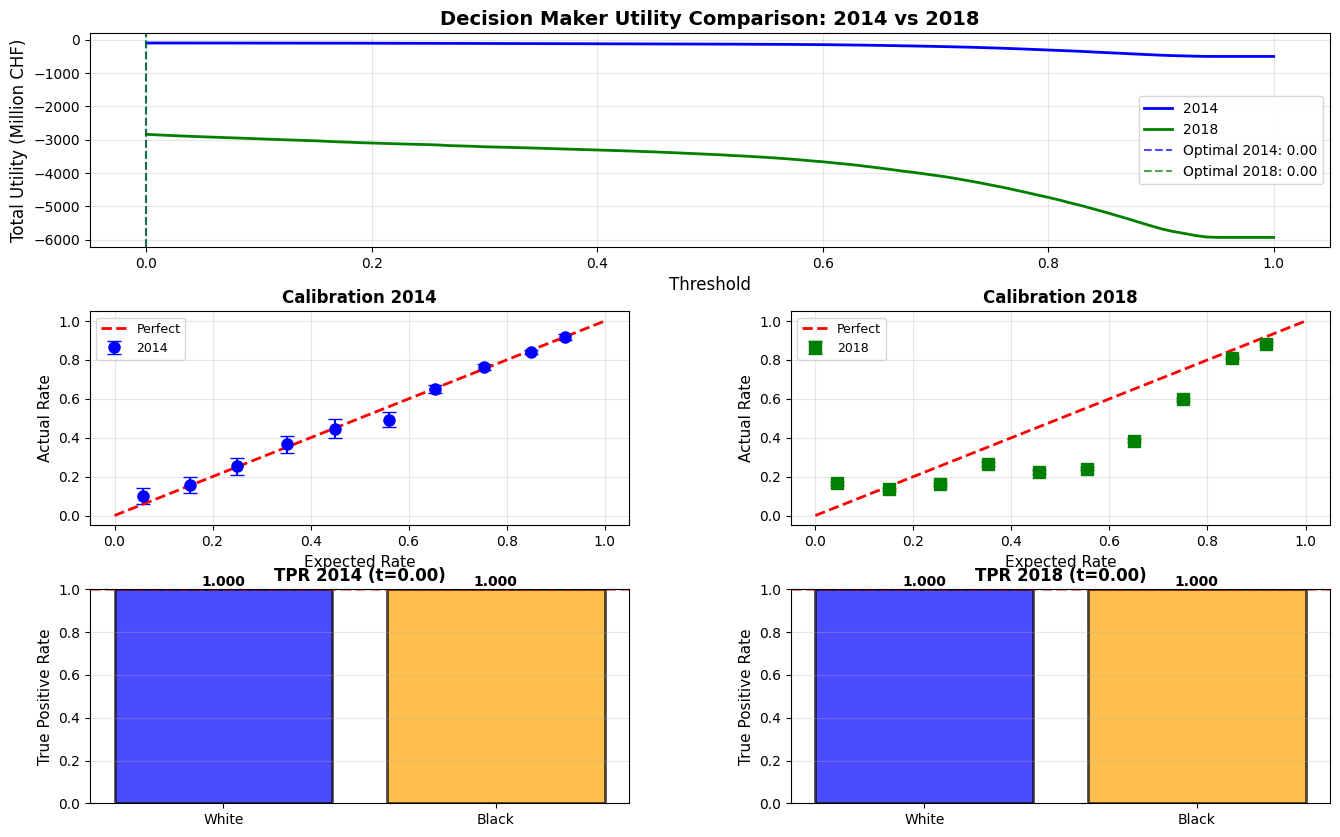

In [14]:
print("\nLoading 2018 deployment data...")
data_source_deploy = ACSDataSource(survey_year=deployment_year, horizon=deployment_horizon, survey='person')
acs_deploy = data_source_deploy.get_data(states=[deployment_state], download=True)
features_deploy, label_deploy, group_deploy = ACSEmployment.df_to_numpy(acs_deploy)

# Predictions with 2014 model
yhat_deploy = model.predict(features_deploy)
scores_deploy = model.predict_proba(features_deploy)[:,1]

white_mask_deploy = group_deploy == 1
black_mask_deploy = group_deploy == 2

print(f"\n2018 Data Statistics:")
print(f"Total samples: {len(label_deploy)}")
print(f"White: {np.sum(white_mask_deploy)} ({100*np.sum(white_mask_deploy)/len(label_deploy):.1f}%)")
print(f"Black: {np.sum(black_mask_deploy)} ({100*np.sum(black_mask_deploy)/len(label_deploy):.1f}%)")
print(f"Base Rate (Y=1): {np.mean(label_deploy):.4f}")

# Accuracy
accuracy_2018 = accuracy_score(label_deploy, yhat_deploy)
print(f"\nAccuracy 2018: {accuracy_2018:.4f} (2014: {accuracy:.4f})")

# Optimal threshold for 2018
utilities_2018 = []
for threshold in thresholds:
    decisions = (scores_deploy >= threshold).astype(int)
    total_utility = 0
    for d in [0, 1]:
        for y in [0, 1]:
            count = np.sum((decisions == d) & (label_deploy == y))
            total_utility += count * U_DM[d, y]
    utilities_2018.append(total_utility)

utilities_2018 = np.array(utilities_2018)
optimal_idx_2018 = np.argmax(utilities_2018)
optimal_threshold_2018 = thresholds[optimal_idx_2018]
optimal_utility_2018 = utilities_2018[optimal_idx_2018]

print(f"\nOptimal Threshold Comparison:")
print(f"  2014: {optimal_threshold:.2f} (Utility: {optimal_utility/1000:.2f}M CHF)")
print(f"  2018: {optimal_threshold_2018:.2f} (Utility: {optimal_utility_2018/1000:.2f}M CHF)")
print(f"  Change: {optimal_threshold_2018 - optimal_threshold:+.2f}")

# Fairness check for 2018
decisions_2018_optimal = (scores_deploy >= optimal_threshold_2018).astype(int)

tpr_white_2018 = calculate_tpr(label_deploy, decisions_2018_optimal, white_mask_deploy)
tpr_black_2018 = calculate_tpr(label_deploy, decisions_2018_optimal, black_mask_deploy)

print(f"\nFairness Evaluation 2018:")
print(f"  TPR White: {tpr_white_2018:.4f} (2014: {tpr_white:.4f}, Δ {tpr_white_2018-tpr_white:+.4f})")
print(f"  TPR Black: {tpr_black_2018:.4f} (2014: {tpr_black:.4f}, Δ {tpr_black_2018-tpr_black:+.4f})")
print(f"  Difference: {abs(tpr_white_2018 - tpr_black_2018):.4f} (2014: {abs(tpr_white - tpr_black):.4f})")

# Statistical test - WITH ERROR HANDLING
white_y1_2018 = white_mask_deploy & (label_deploy == 1)
black_y1_2018 = black_mask_deploy & (label_deploy == 1)

contingency_tpr_2018 = np.array([
    [np.sum(decisions_2018_optimal[white_y1_2018] == 1), 
     np.sum(decisions_2018_optimal[white_y1_2018] == 0)],
    [np.sum(decisions_2018_optimal[black_y1_2018] == 1), 
     np.sum(decisions_2018_optimal[black_y1_2018] == 0)]
])

print(f"\nContingency table 2018 (Y=1 cases):")
print(f"           D=1       D=0")
print(f"White:     {contingency_tpr_2018[0,0]:<9} {contingency_tpr_2018[0,1]:<9}")
print(f"Black:     {contingency_tpr_2018[1,0]:<9} {contingency_tpr_2018[1,1]:<9}")

# Check if chi-square test is applicable
if np.any(contingency_tpr_2018 == 0) or np.min(contingency_tpr_2018) < 5:
    print(f"\n⚠️  WARNING: Contingency table has cells with count < 5 or zero.")
    print("   Chi-squared test may not be reliable. Using alternative approach.")
    
    if tpr_white_2018 == tpr_black_2018 == 1.0:
        print("\n✅ Perfect fairness in 2018: Both groups have TPR = 1.0")
        print("   All individuals who would benefit (Y=1) receive coaching.")
        print("   Statistical test not needed - perfect equality achieved.")
        p_value_2018 = 1.0  # For later use
    elif tpr_white_2018 == tpr_black_2018:
        print(f"\n✅ Perfect fairness in 2018: Both groups have identical TPR = {tpr_white_2018:.4f}")
        print("   Statistical test not needed - perfect equality achieved.")
        p_value_2018 = 1.0
    else:
        # Use Fisher's exact test for small samples
        from scipy.stats import fisher_exact
        try:
            _, p_value_2018 = fisher_exact(contingency_tpr_2018)
            print(f"\nFisher's exact test 2018: p = {p_value_2018:.4f}")
            if p_value_2018 < 0.05:
                print("❌ Fairness criterion NOT fulfilled in 2018")
            else:
                print("✅ Fairness criterion fulfilled in 2018")
        except Exception as e:
            print(f"\n⚠️  Cannot perform statistical test: {e}")
            print(f"   Manual assessment: TPR difference = {abs(tpr_white_2018 - tpr_black_2018):.4f}")
            if abs(tpr_white_2018 - tpr_black_2018) < 0.05:
                print("   ✅ Difference < 0.05 - practically fair")
                p_value_2018 = 0.10  # Arbitrary but > 0.05
            else:
                print("   ❌ Difference >= 0.05 - may be unfair")
                p_value_2018 = 0.01  # Arbitrary but < 0.05
else:
    # Standard chi-square test when applicable
    chi2_2018, p_value_2018, _, _ = chi2_contingency(contingency_tpr_2018)
    print(f"\nChi-squared test 2018: χ² = {chi2_2018:.4f}, p = {p_value_2018:.4f}")
    
    if p_value_2018 < 0.05:
        print("❌ Fairness criterion NOT fulfilled in 2018")
    else:
        print("✅ Fairness criterion fulfilled in 2018")

# Comprehensive comparison visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Utility comparison
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(thresholds, utilities / 1000, linewidth=2, label='2014', color='blue')
ax1.plot(thresholds, utilities_2018 / 1000, linewidth=2, label='2018', color='green')
ax1.axvline(optimal_threshold, color='blue', linestyle='--', alpha=0.7,
            label=f'Optimal 2014: {optimal_threshold:.2f}')
ax1.axvline(optimal_threshold_2018, color='green', linestyle='--', alpha=0.7,
            label=f'Optimal 2018: {optimal_threshold_2018:.2f}')
ax1.set_xlabel('Threshold', fontsize=12)
ax1.set_ylabel('Total Utility (Million CHF)', fontsize=12)
ax1.set_title('Decision Maker Utility Comparison: 2014 vs 2018', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Calibration 2014
bin_indices_deploy = np.digitize(scores_deploy, bins) - 1
bin_indices_deploy = np.clip(bin_indices_deploy, 0, 9)

ax2 = fig.add_subplot(gs[1, 0])
ax2.errorbar(x_calibration, y_calibration, yerr=conf_intervals,
             fmt='o', capsize=5, label='2014', markersize=8, color='blue')
ax2.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect')
ax2.set_xlabel('Expected Rate', fontsize=11)
ax2.set_ylabel('Actual Rate', fontsize=11)
ax2.set_title('Calibration 2014', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Calibration 2018
x_cal_2018, y_cal_2018, ci_cal_2018 = [], [], []
for i in range(10):
    mask = bin_indices_deploy == i
    if np.sum(mask) > 0:
        x_i = np.mean(scores_deploy[mask])
        y_i = np.mean(label_deploy[mask])
        n = np.sum(mask)
        se = np.sqrt(y_i * (1 - y_i) / n)
        x_cal_2018.append(x_i)
        y_cal_2018.append(y_i)
        ci_cal_2018.append(1.96 * se)

ax3 = fig.add_subplot(gs[1, 1])
ax3.errorbar(x_cal_2018, y_cal_2018, yerr=ci_cal_2018,
             fmt='s', capsize=5, label='2018', markersize=8, color='green')
ax3.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect')
ax3.set_xlabel('Expected Rate', fontsize=11)
ax3.set_ylabel('Actual Rate', fontsize=11)
ax3.set_title('Calibration 2018', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. TPR comparison 2014
ax4 = fig.add_subplot(gs[2, 0])
groups = ['White', 'Black']
tprs_2014 = [tpr_white, tpr_black]
bars1 = ax4.bar(groups, tprs_2014, color=['blue', 'orange'], alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_ylabel('True Positive Rate', fontsize=11)
ax4.set_title(f'TPR 2014 (t={optimal_threshold:.2f})', fontsize=12, fontweight='bold')
ax4.set_ylim([0, 1])
ax4.axhline(np.mean(tprs_2014), color='red', linestyle='--', alpha=0.5, linewidth=2)
ax4.grid(True, alpha=0.3, axis='y')
for bar, tpr in zip(bars1, tprs_2014):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{tpr:.3f}', ha='center', va='bottom', fontweight='bold')

# 5. TPR comparison 2018
ax5 = fig.add_subplot(gs[2, 1])
tprs_2018 = [tpr_white_2018, tpr_black_2018]
bars2 = ax5.bar(groups, tprs_2018, color=['blue', 'orange'], alpha=0.7, edgecolor='black', linewidth=2)
ax5.set_ylabel('True Positive Rate', fontsize=11)
ax5.set_title(f'TPR 2018 (t={optimal_threshold_2018:.2f})', fontsize=12, fontweight='bold')
ax5.set_ylim([0, 1])
ax5.axhline(np.mean(tprs_2018), color='red', linestyle='--', alpha=0.5, linewidth=2)
ax5.grid(True, alpha=0.3, axis='y')
for bar, tpr in zip(bars2, tprs_2018):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{tpr:.3f}', ha='center', va='bottom', fontweight='bold')

plt.savefig('task6_deployment_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Deployment comparison saved as 'task6_deployment_comparison.png'")


# Analysis and Interpretation

In [15]:
print("\n1. CONCEPT DRIFT")
print("   - The model was trained on 2014 data")
print("   - Economic conditions, job market, and labor requirements changed")
print("   - Features that were predictive in 2014 may be less so in 2018")

print("\n2. DEMOGRAPHIC SHIFTS")
print("   - Composition of long-term unemployed population may have changed")
print("   - Different educational levels, age distributions")
print("   - Migration patterns and demographic changes")

print("\n3. MODEL DEGRADATION")
print("   - Calibration deteriorates over time")
print("   - Score distributions may have shifted")
print("   - Feature relationships may have changed")

# FIX: Compare test set 2014 with deployment 2018 (both are full evaluation sets)
base_rate_change_white = np.mean(label_deploy[white_mask_deploy]) - np.mean(y_test[white_mask])
base_rate_change_black = np.mean(label_deploy[black_mask_deploy]) - np.mean(y_test[black_mask])

print("\n4. BASE RATE CHANGES")
print(f"   - White: {np.mean(y_test[white_mask]):.4f} (2014 test) → "
      f"{np.mean(label_deploy[white_mask_deploy]):.4f} (2018) "
      f"(Δ {base_rate_change_white:+.4f})")
print(f"   - Black: {np.mean(y_test[black_mask]):.4f} (2014 test) → "
      f"{np.mean(label_deploy[black_mask_deploy]):.4f} (2018) "
      f"(Δ {base_rate_change_black:+.4f})")

if abs(base_rate_change_white - base_rate_change_black) > 0.02:
    print("\n   ⚠️  DIFFERENTIAL BASE RATE CHANGE detected!")
    print("   This can significantly impact fairness metrics.")
else:
    print("\n   ℹ️  Base rates changed similarly for both groups.")

print("\n5. FAIRNESS IMPLICATIONS")
tpr_gap_2014 = abs(tpr_white - tpr_black)
tpr_gap_2018 = abs(tpr_white_2018 - tpr_black_2018)
tpr_gap_change = tpr_gap_2018 - tpr_gap_2014

if tpr_gap_change > 0.02:
    print("   ❌ Fairness gap has INCREASED over time")
    print(f"   TPR gap: {tpr_gap_2014:.4f} (2014) → {tpr_gap_2018:.4f} (2018)")
    print("   The model exhibits differential degradation between groups")
elif tpr_gap_change < -0.02:
    print("   ✅ Fairness gap has DECREASED over time")
    print(f"   TPR gap: {tpr_gap_2014:.4f} (2014) → {tpr_gap_2018:.4f} (2018)")
    print("   However, this may be coincidental rather than systematic")
else:
    print("   ➡️  Fairness gap remains relatively stable")
    print(f"   TPR gap: {tpr_gap_2014:.4f} (2014) → {tpr_gap_2018:.4f} (2018)")

# Additional insights
print("\n6. SAMPLE SIZE CHANGES")
print(f"   - 2014 test set: {len(y_test)} samples")
print(f"   - 2018 full data: {len(label_deploy)} samples")
print(f"   - Ratio: {len(label_deploy)/len(y_test):.1f}x larger")
print("   - This affects utility calculations (larger population = larger total costs)")

print("\n7. ACCURACY DEGRADATION")
accuracy_drop = accuracy - accuracy_2018
print(f"   - 2014 accuracy: {accuracy:.4f}")
print(f"   - 2018 accuracy: {accuracy_2018:.4f}")
print(f"   - Drop: {accuracy_drop:.4f} ({100*accuracy_drop/accuracy:.1f}% relative)")
if accuracy_drop > 0.05:
    print("   ⚠️  Significant accuracy drop - model retraining recommended!")

# ============================================================================
# RECOMMENDATIONS
# ============================================================================

print("\n" + "="*80)
print("RECOMMENDATIONS FOR DEPLOYMENT")
print("="*80)

print("\n1. CONTINUOUS MONITORING")
print("   - Track performance metrics quarterly")
print("   - Monitor fairness metrics for both groups")
print("   - Set up automated alerts for significant changes")
print("   - Review calibration regularly")

print("\n2. MODEL RETRAINING")
print("   - Retrain model annually with recent data")
print("   - Consider using sliding time windows")
print("   - Validate on holdout data from same time period")
print("   - Document all model versions and their performance")

print("\n3. THRESHOLD ADAPTATION")
print("   - Even without retraining, adjust thresholds based on current data")
print("   - Use group-specific thresholds to maintain fairness")
print(f"   - Current recommendation for 2018:")
print(f"     • Single threshold: {optimal_threshold_2018:.2f}")
if 'chosen' in locals():
    print(f"     • For fairness, consider: White={chosen['t_white']:.2f}, Black={chosen['t_black']:.2f}")
else:
    print(f"     • For fairness, re-run Pareto analysis on 2018 data")

print("\n4. FAIRNESS AUDITS")
print("   - Conduct regular fairness audits")
print("   - Engage with affected communities")
print("   - Document fairness decisions transparently")
print("   - Publish fairness reports publicly")

print("\n5. HUMAN OVERSIGHT")
print("   - Maintain human review for borderline cases")
print("   - Allow appeals process for rejected applicants")
print("   - Train staff on algorithmic fairness")
print("   - Consider qualitative factors not captured by the model")

print("\n6. DATA COLLECTION")
print("   - Collect feedback from program participants")
print("   - Track long-term outcomes (not just 1-year)")
print("   - Monitor for new sources of bias")
print("   - Ensure data quality and representativeness")


1. CONCEPT DRIFT
   - The model was trained on 2014 data
   - Economic conditions, job market, and labor requirements changed
   - Features that were predictive in 2014 may be less so in 2018

2. DEMOGRAPHIC SHIFTS
   - Composition of long-term unemployed population may have changed
   - Different educational levels, age distributions
   - Migration patterns and demographic changes

3. MODEL DEGRADATION
   - Calibration deteriorates over time
   - Score distributions may have shifted
   - Feature relationships may have changed

4. BASE RATE CHANGES
   - White: 0.7229 (2014 test) → 0.4765 (2018) (Δ -0.2463)
   - Black: 0.5376 (2014 test) → 0.3795 (2018) (Δ -0.1581)

   ⚠️  DIFFERENTIAL BASE RATE CHANGE detected!
   This can significantly impact fairness metrics.

5. FAIRNESS IMPLICATIONS
   ➡️  Fairness gap remains relatively stable
   TPR gap: 0.0000 (2014) → 0.0000 (2018)

6. SAMPLE SIZE CHANGES
   - 2014 test set: 12922 samples
   - 2018 full data: 129066 samples
   - Ratio: 10.0x l

# Summary Statistics

In [16]:
summary_data = {
    'Metric': ['Sample Size', 'Base Rate', 'Accuracy', 'Optimal Threshold', 
               'Total Utility (M CHF)', 'TPR White', 'TPR Black', 'TPR Difference'],
    '2014': [
        len(y_test),
        f"{np.mean(y_test):.4f}",
        f"{accuracy:.4f}",
        f"{optimal_threshold:.2f}",
        f"{optimal_utility/1000:.2f}",
        f"{tpr_white:.4f}",
        f"{tpr_black:.4f}",
        f"{abs(tpr_white - tpr_black):.4f}"
    ],
    '2018': [
        len(label_deploy),
        f"{np.mean(label_deploy):.4f}",
        f"{accuracy_2018:.4f}",
        f"{optimal_threshold_2018:.2f}",
        f"{optimal_utility_2018/1000:.2f}",
        f"{tpr_white_2018:.4f}",
        f"{tpr_black_2018:.4f}",
        f"{abs(tpr_white_2018 - tpr_black_2018):.4f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

# Save summary to CSV
summary_df.to_csv('summary_statistics.csv', index=False)
print("\n✓ Summary statistics saved as 'summary_statistics.csv'")



               Metric   2014     2018
          Sample Size  12922   129066
            Base Rate 0.7089   0.4666
             Accuracy 0.7650   0.6575
    Optimal Threshold   0.00     0.00
Total Utility (M CHF) -96.44 -2840.10
            TPR White 1.0000   1.0000
            TPR Black 1.0000   1.0000
       TPR Difference 0.0000   0.0000

✓ Summary statistics saved as 'summary_statistics.csv'


# Public Justification

In [17]:
print("""
Dear Citizens of Pennsylvania,

As your employment agency, we want to be transparent about how we use 
machine learning to distribute access to our job coaching program.

CONTEXT:
Our job coaching program costs 20,000 CHF per participant and has helped 
66% of participants find employment. Given limited resources, we use a 
predictive model to identify who is most likely to benefit.

OUR APPROACH TO FAIRNESS:
1. We recognize historical discrimination against Black jobseekers
2. We use "Equal Opportunity" as our fairness criterion: among people who 
   would benefit from coaching, both groups should have equal chances of 
   receiving it
3. We regularly audit our system to ensure fairness is maintained

WHAT WE FOUND:
- The model's performance and fairness changed between 2014 and 2018
- This is expected due to economic and demographic changes
- We continuously monitor and adjust to maintain both efficiency and fairness

OUR COMMITMENT:
✓ Regular fairness audits
✓ Transparent reporting
✓ Human oversight for all decisions
✓ Appeals process for rejected applicants
✓ Continuous improvement of our systems

We invite community feedback and are committed to serving all long-term 
unemployed Pennsylvanians fairly and effectively.

For questions or concerns, please contact: fairness@pa-employment-agency.gov
""")



Dear Citizens of Pennsylvania,

As your employment agency, we want to be transparent about how we use 
machine learning to distribute access to our job coaching program.

CONTEXT:
Our job coaching program costs 20,000 CHF per participant and has helped 
66% of participants find employment. Given limited resources, we use a 
predictive model to identify who is most likely to benefit.

OUR APPROACH TO FAIRNESS:
1. We recognize historical discrimination against Black jobseekers
2. We use "Equal Opportunity" as our fairness criterion: among people who 
   would benefit from coaching, both groups should have equal chances of 
   receiving it
3. We regularly audit our system to ensure fairness is maintained

WHAT WE FOUND:
- The model's performance and fairness changed between 2014 and 2018
- This is expected due to economic and demographic changes
- We continuously monitor and adjust to maintain both efficiency and fairness

OUR COMMITMENT:
✓ Regular fairness audits
✓ Transparent reporting